# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/MyDrive/CS 445/Project 2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [ ]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [ ]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    def sample_patch():
        in_H, in_W, _ = sample.shape
        i, j = np.random.randint(low=0, high=[in_H-patch_size, in_W-patch_size])
        patch = sample[i:i+patch_size, j:j+patch_size, :].copy()
        return patch

    res = np.zeros((out_size, out_size, 3), dtype='i')
    sample_patch()

    N = out_size // patch_size
    for i in range(N):
        for j in range(N):
            patch = sample_patch()
            x, y = i*patch_size, j*patch_size
            res[x:x+patch_size, y:y+patch_size, :] = patch

    return res

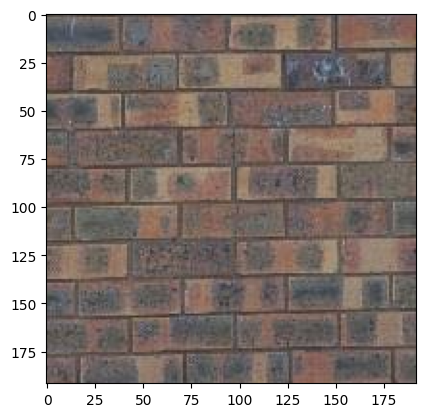

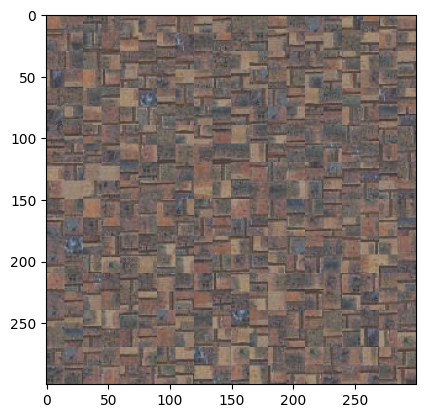

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def sample_first():
        in_H, in_W, _ = sample.shape
        i, j = np.random.randint(low=0, high=[in_H-patch_size, in_W-patch_size])
        patch = sample[i:i+patch_size, j:j+patch_size, :].copy()
        return patch

    def ssd_patch(I, T, M):
        in_H, in_W, _ = I.shape
        ssd_cost = np.zeros((in_H, in_W), dtype='f')

        # calculate ssd cost for 3 channels
        for ch in range(3):
            ssd_cost += ((M*T[:,:,ch])**2).sum() \
                        - 2 * cv2.filter2D(I[:,:,ch], ddepth=-1, kernel = M*T[:,:,ch]) \
                        + cv2.filter2D(I[:,:,ch] ** 2, ddepth=-1, kernel=M)

        # set border to high cost
        max_val = ssd_cost.max()
        hf_ps = patch_size // 2
        ssd_cost[:hf_ps, :] = max_val
        ssd_cost[-hf_ps:, :] = max_val
        ssd_cost[:, :hf_ps] = max_val
        ssd_cost[:, -hf_ps:] = max_val
        return ssd_cost

    def choose_sample(ssd_cost):
        indices = np.argsort(ssd_cost, axis=None)[:tol]
        x, y = np.unravel_index(np.random.choice(indices), ssd_cost.shape)
        hf_ps = patch_size // 2
        patch = sample[x-hf_ps:x+hf_ps+1, y-hf_ps:y+hf_ps+1].copy()
        return patch

    sample = sample.astype('f')
    res = np.zeros((out_size, out_size, 3), dtype='f')
    increment = patch_size - overlap
    n_row, n_col = (out_size-patch_size)//increment + 1, \
                   (out_size-patch_size)//increment + 1

    # sample the patches
    for i in range(n_row):
        for j in range(n_col):
            # sample a random patch for the upper-left corner
            if (i, j) == (0, 0):
                res[:patch_size, :patch_size] = sample_first()
            else:
                # generate mask
                M = np.zeros((patch_size, patch_size), dtype='f')
                if i > 0:
                    M[:overlap, :] = 1.0
                if j > 0:
                    M[:, :overlap] = 1.0

                # get template
                x, y = i*increment, j*increment
                T = res[x:x+patch_size, y:y+patch_size].copy()

                # calculate ssd_cost
                ssd_cost = ssd_patch(sample, T, M)

                # get patch with smallest ssd_cost
                patch = choose_sample(ssd_cost)

                # copy patch to result
                res[x:x+patch_size, y:y+patch_size] = patch

    return res.astype('i')

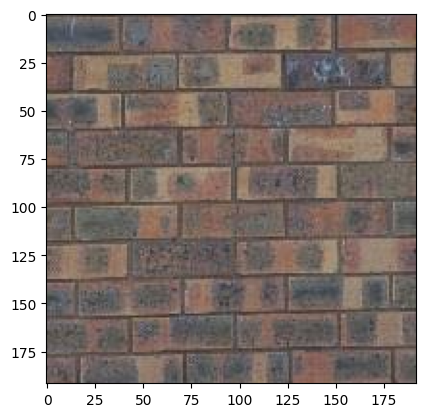

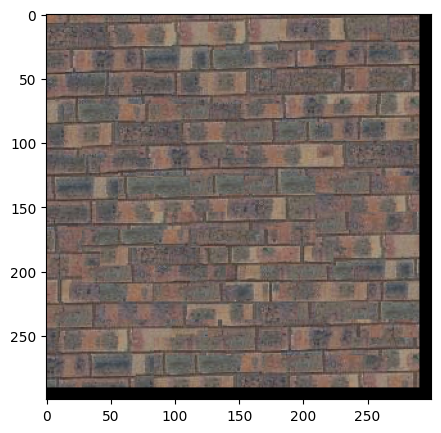

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# sample_img.shape: (192, 192, 3)

plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def sample_first():
        in_H, in_W, _ = sample.shape
        i, j = np.random.randint(low=0, high=[in_H-patch_size, in_W-patch_size])
        patch = sample[i:i+patch_size, j:j+patch_size, :].copy()
        return patch

    def ssd_patch(I, T, M):
        in_H, in_W, _ = I.shape
        ssd_cost = np.zeros((in_H, in_W), dtype='f')

        # calculate ssd cost for 3 channels
        for ch in range(3):
            ssd_cost += ((M*T[:,:,ch])**2).sum() \
                        - 2 * cv2.filter2D(I[:,:,ch], ddepth=-1, kernel = M*T[:,:,ch]) \
                        + cv2.filter2D(I[:,:,ch] ** 2, ddepth=-1, kernel=M)

        # set border to high cost
        max_val = ssd_cost.max()
        hf_ps = patch_size // 2
        ssd_cost[:hf_ps, :] = max_val
        ssd_cost[-hf_ps:, :] = max_val
        ssd_cost[:, :hf_ps] = max_val
        ssd_cost[:, -hf_ps:] = max_val
        return ssd_cost

    def choose_sample(ssd_cost):
        indices = np.argsort(ssd_cost, axis=None)[:tol]
        x, y = np.unravel_index(np.random.choice(indices), ssd_cost.shape)
        hf_ps = patch_size // 2
        patch = sample[x-hf_ps:x+hf_ps+1, y-hf_ps:y+hf_ps+1].copy()
        return patch

    def combine_patch(x, y, T, patch, print_res):
        mask1, mask2 = np.ones(patch.shape[:2], dtype='i'), np.ones(patch.shape[:2], dtype='i')

        # has top overlap
        if x > 0:
            region0, region1 = T[:overlap, :], patch[:overlap, :]
            err_patch = np.sum((region0 - region1) ** 2, axis=2)
            mask1[:overlap, :] = np.logical_and(mask1[:overlap, :], cut(err_patch))
            if print_res:
                plt.figure(figsize=(5,2))
                plt.imshow(err_patch)
                plt.figure(figsize=(5,5))
                plt.imshow(mask1, cmap='gray')

        # has left overlap
        if y > 0:
            region0, region1 = T[:, :overlap], patch[:, :overlap]
            err_patch = np.sum((region0 - region1) ** 2, axis=2)
            mask2[:, :overlap] = np.logical_and(mask2[:, :overlap], cut(err_patch.T).T)
            if print_res:
                plt.figure(figsize=(2,5))
                plt.imshow(err_patch)
                plt.figure(figsize=(5,5))
                plt.imshow(mask2, cmap='gray')

        mask = np.logical_and(mask1, mask2)
        mask = np.expand_dims(mask, axis=2)
        new_patch = mask * patch + (1 - mask) * T
        if print_res:
            plt.figure(figsize=(5,5))
            plt.imshow(mask, cmap='gray')
            plt.figure(figsize=(5,5))
            plt.imshow(((1 - mask) * T).astype('i'))

        return new_patch

    sample = sample.astype('f')
    res = np.zeros((out_size, out_size, 3), dtype='f')
    increment = patch_size - overlap
    n_row, n_col = (out_size-patch_size)//increment + 1, \
                   (out_size-patch_size)//increment + 1

    # sample the patches
    for i in range(n_row):
        for j in range(n_col):
            # sample a random patch for the upper-left corner
            if (i, j) == (0, 0):
                res[:patch_size, :patch_size] = sample_first()
            else:
                # print_res = True if i == 10 and j == 15 else False
                print_res = False

                # generate mask
                M = np.zeros((patch_size, patch_size), dtype='f')
                if i > 0:
                    M[:overlap, :] = 1.0
                if j > 0:
                    M[:, :overlap] = 1.0

                # get template
                x, y = i*increment, j*increment
                T = res[x:x+patch_size, y:y+patch_size].copy()

                # calculate ssd_cost
                ssd_cost = ssd_patch(sample, T, M)

                if print_res:
                    plt.figure(figsize=(5,5))
                    plt.imshow(T.astype('i'))
                    plt.figure(figsize=(5,5))
                    plt.imshow(ssd_cost.astype('i'))
                    plt.colorbar()

                # get patch with smallest ssd_cost
                patch = choose_sample(ssd_cost)

                # apply seam finding
                new_patch = combine_patch(x, y, T, patch, print_res)

                # copy patch to result
                res[x:x+patch_size, y:y+patch_size] = new_patch

    return res.astype('i')

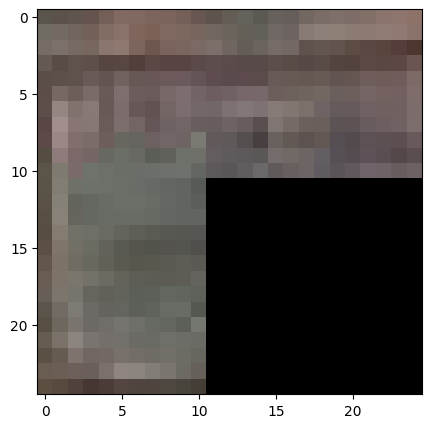

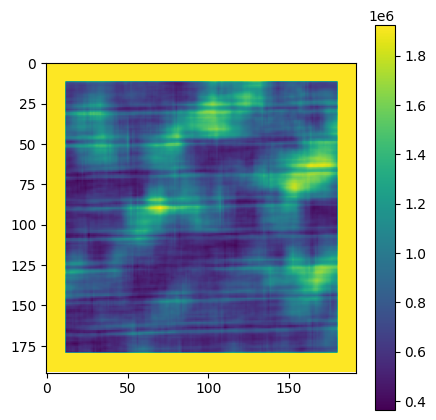

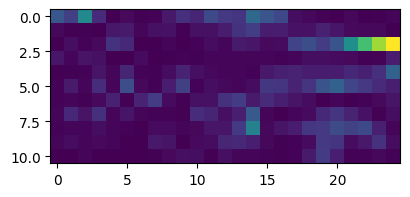

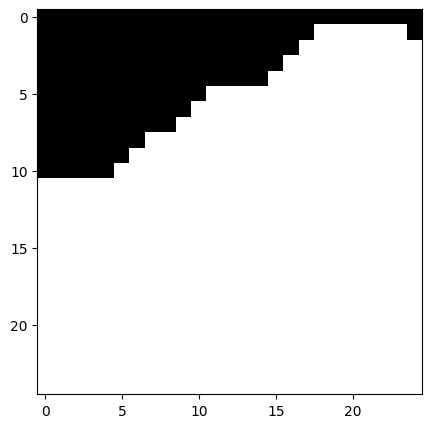

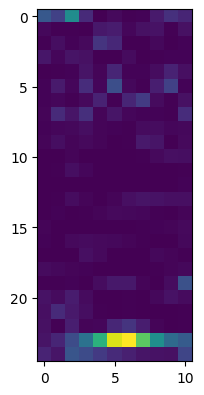

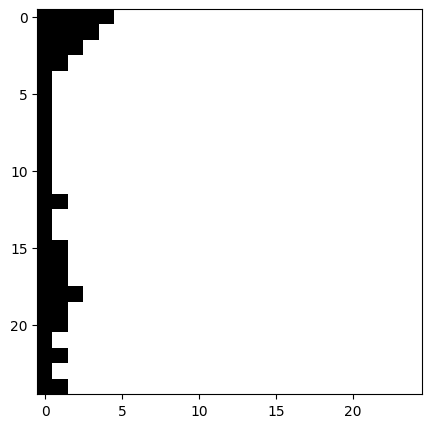

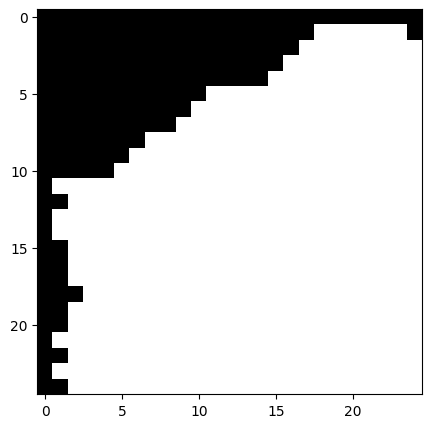

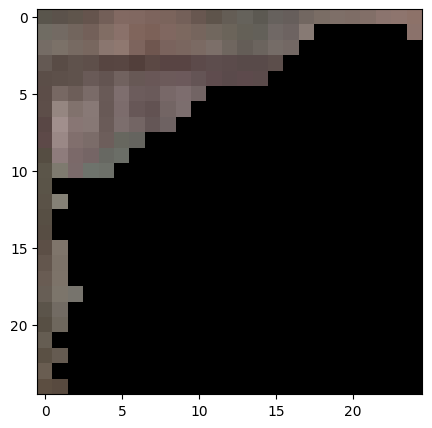

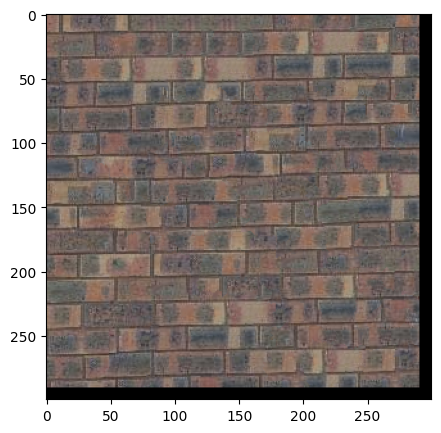

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# plt.imshow(sample_img)
# plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

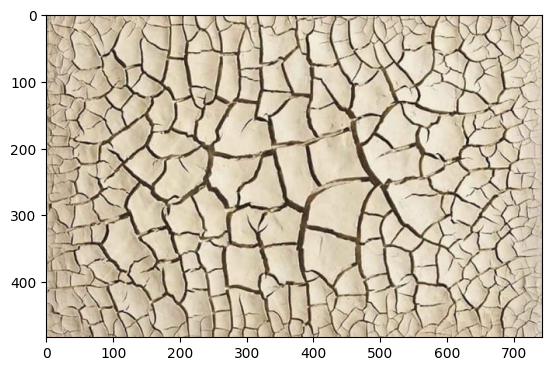

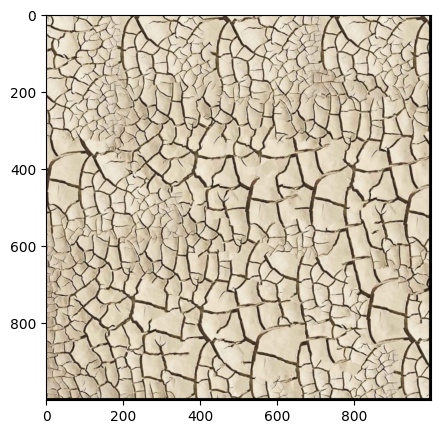

In [ ]:
# More quilting results
sample_img_fn = 'samples/texture1.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 1000  # change these parameters as needed
patch_size = 75
overlap = 35
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

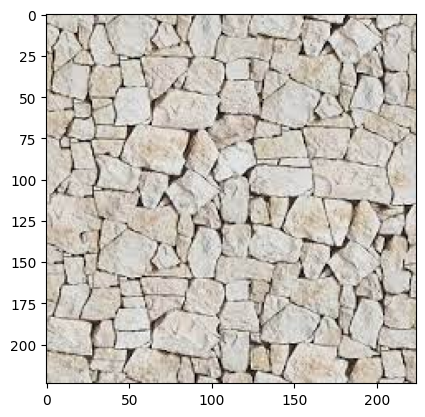

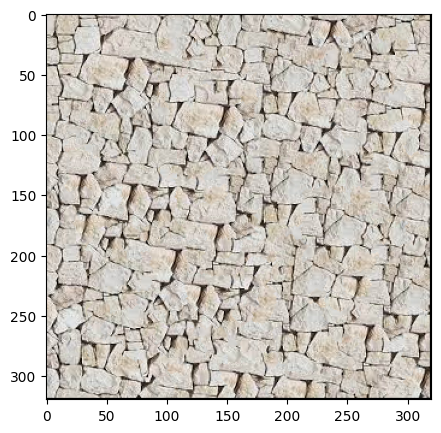

In [ ]:
# More quilting results
sample_img_fn = 'samples/texture2.jpeg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 320  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(texture_im, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: input texture image, numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    def ssd_patch(I, T, M):
        ssd_cost = np.zeros(I.shape[:2], dtype='f')

        # calculate ssd cost for 3 channels
        for ch in range(3):
            ssd_cost += ((M*T[:,:,ch])**2).sum() \
                        - 2 * cv2.filter2D(I[:,:,ch], ddepth=-1, kernel = M*T[:,:,ch]) \
                        + cv2.filter2D(I[:,:,ch] ** 2, ddepth=-1, kernel=M)

        # set border to high cost
        max_val = ssd_cost.max()
        hf_ps = patch_size // 2
        ssd_cost[:hf_ps, :] = max_val
        ssd_cost[-hf_ps:, :] = max_val
        ssd_cost[:, :hf_ps] = max_val
        ssd_cost[:, -hf_ps:] = max_val
        return ssd_cost

    def choose_sample(ssd_cost):
        indices = np.argsort(ssd_cost, axis=None)[:tol]
        x, y = np.unravel_index(np.random.choice(indices), ssd_cost.shape)
        hf_ps = patch_size // 2
        patch = texture_im[x-hf_ps:x+hf_ps+1, y-hf_ps:y+hf_ps+1].copy()
        return patch

    def combine_patch(x, y, T, patch):
        mask = np.ones(patch.shape[:2], dtype='i')

        # has top overlap
        if x > 0:
            region0, region1 = T[:overlap, :], patch[:overlap, :]
            err_patch = np.sum((region0 - region1) ** 2, axis=2)
            mask[:overlap, :] = np.logical_and(mask[:overlap, :], cut(err_patch))

        # has left overlap
        if y > 0:
            region0, region1 = T[:, :overlap], patch[:, :overlap]
            err_patch = np.sum((region0 - region1) ** 2, axis=2)
            mask[:, :overlap] = np.logical_and(mask[:, :overlap], cut(err_patch.T).T)

        mask = np.expand_dims(mask, axis=2)
        new_patch = mask * patch + (1 - mask) * T
        return new_patch

    out_H, out_W = guidance_im.shape[:2]
    texture_im, guidance_im = texture_im.astype('f'), guidance_im.astype('f')
    res = np.zeros((out_H, out_W, 3), dtype='f')
    increment = patch_size - overlap
    n_row, n_col = (out_H-patch_size)//increment + 1, \
                   (out_W-patch_size)//increment + 1

    # sample the patches
    for i in range(n_row):
        for j in range(n_col):
            # generate mask
            M1 = np.zeros((patch_size, patch_size), dtype='f')
            if i > 0:
                M1[:overlap, :] = 1.0
            if j > 0:
                M1[:, :overlap] = 1.0
            M2 = np.ones((patch_size, patch_size), dtype='f')

            # get template
            x, y = i*increment, j*increment
            T1 = res[x:x+patch_size, y:y+patch_size].copy()
            T2 = guidance_im[x:x+patch_size, y:y+patch_size].copy()

            # calculate ssd_cost
            ssd_cost = alpha * ssd_patch(texture_im, T1, M1)\
                       + (1 - alpha) * ssd_patch(texture_im, T2, M2)

            # get patch with smallest ssd_cost
            patch = choose_sample(ssd_cost)

            # apply seam finding
            new_patch = combine_patch(x, y, T1, patch)

            # copy patch to result
            res[x:x+patch_size, y:y+patch_size] = new_patch

    return res.astype('i')

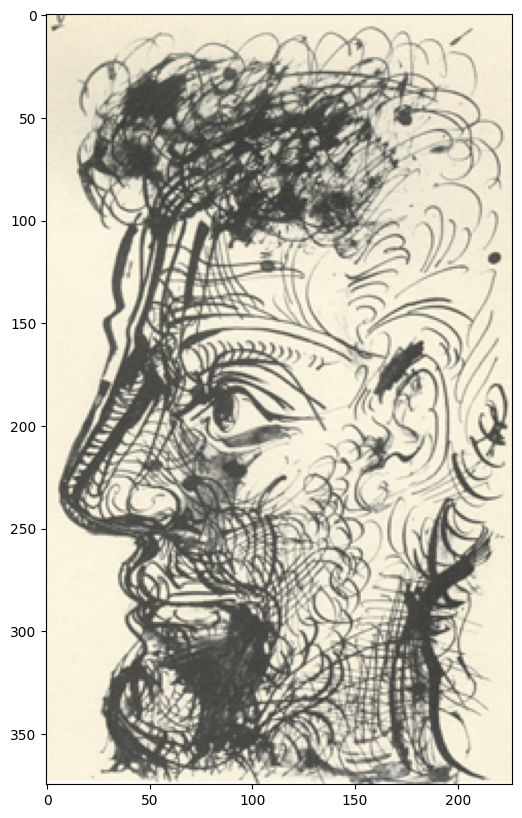

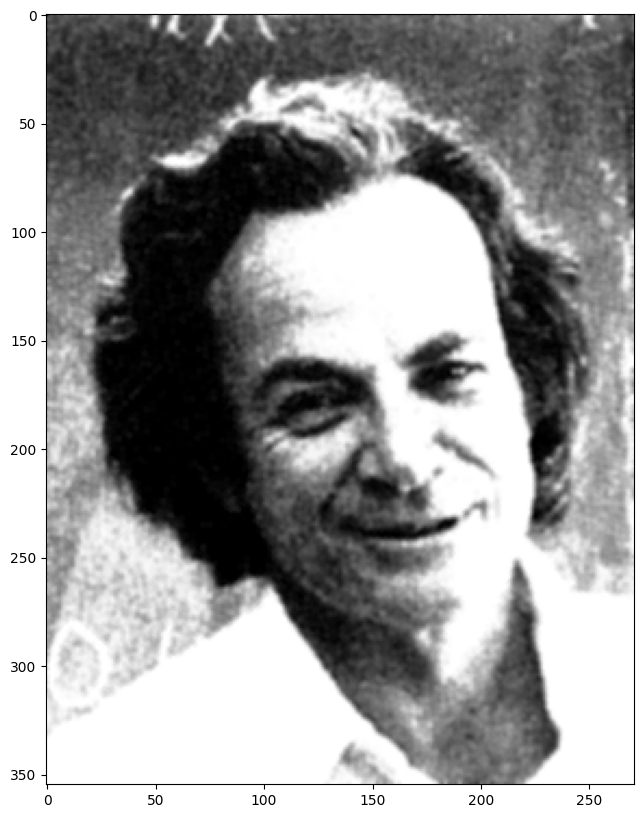

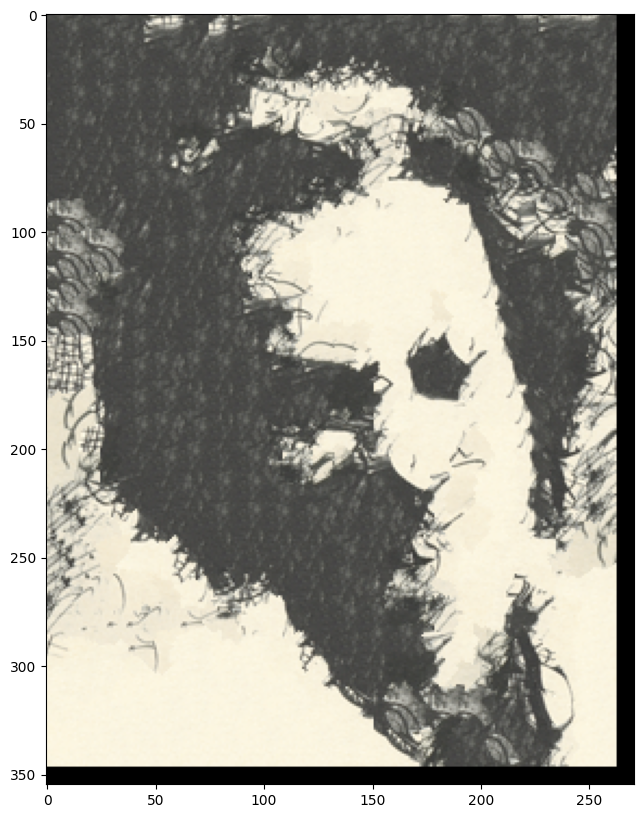

In [ ]:
# load/process appropriate input texture and guidance images
texture_img = cv2.cvtColor(cv2.imread("samples/sketch.tiff"), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread("samples/feynman.tiff"), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(texture_img)
plt.figure(figsize=(10,10))
plt.imshow(guidance_img)

patch_size = 25
overlap = 11
tol = 5
alpha = 0.1
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

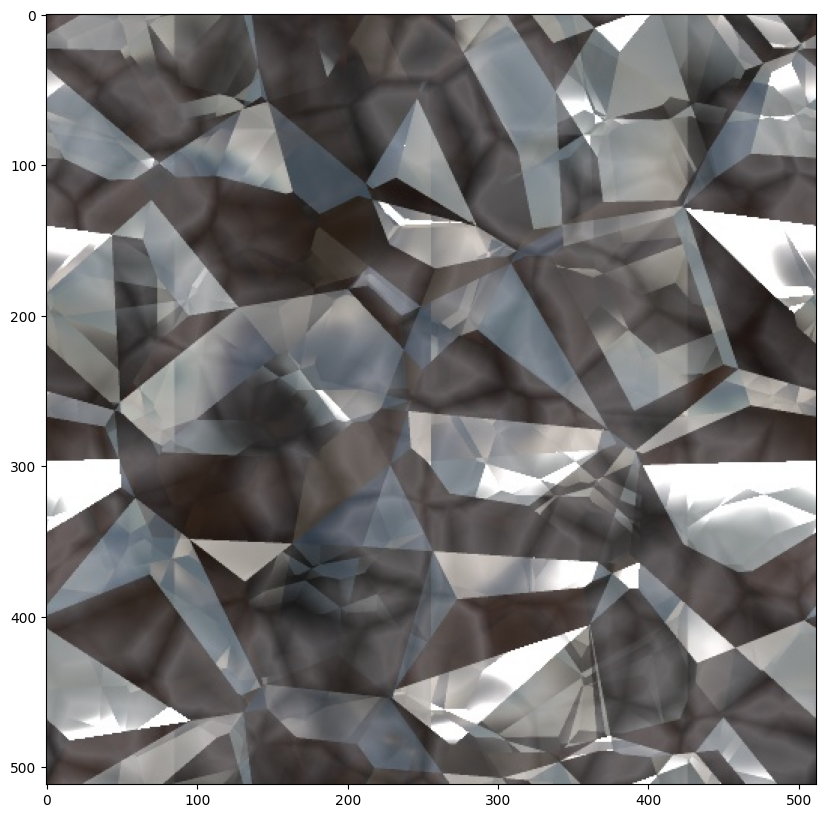

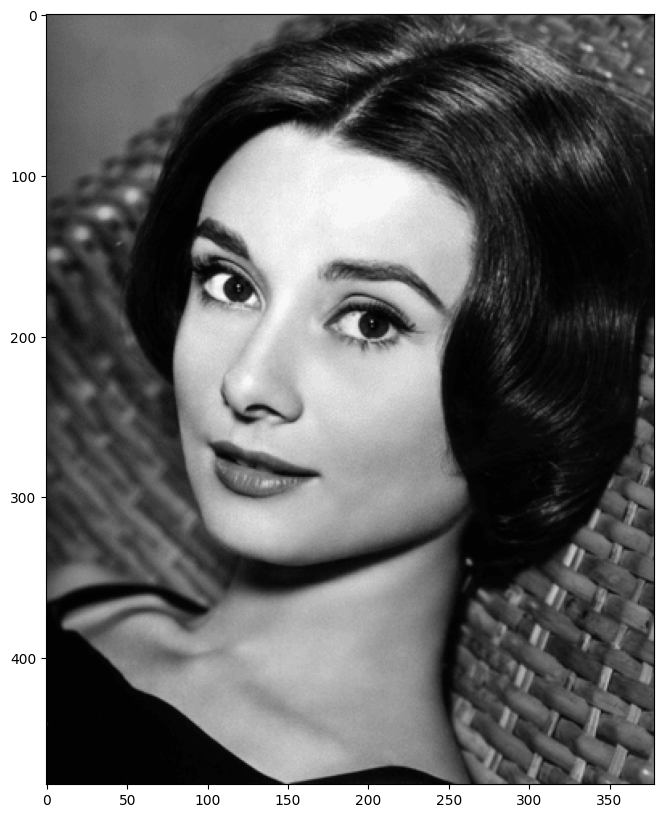

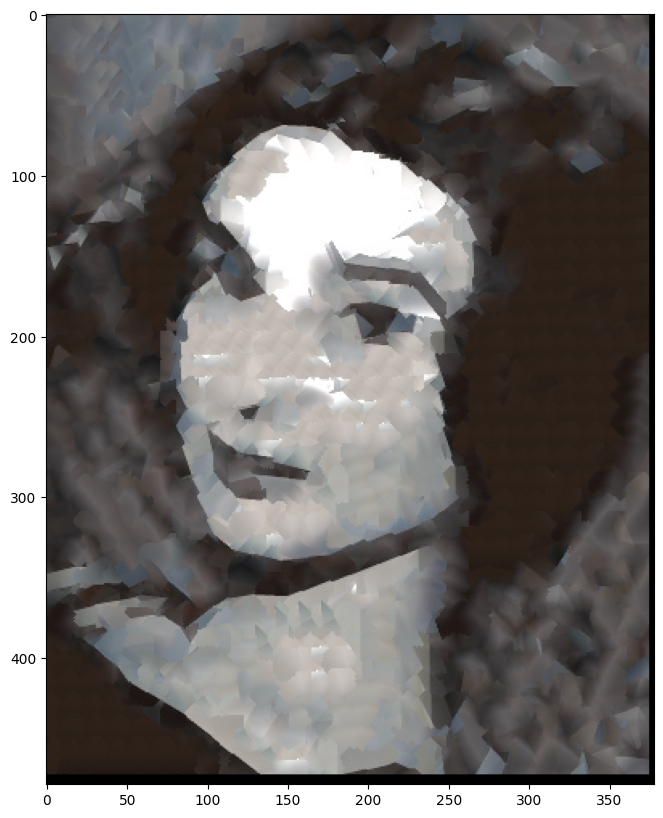

In [ ]:
# More texture transfer
texture_img = cv2.cvtColor(cv2.imread("samples/texture3.jpg"), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread("samples/audrey_bw.png"), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(texture_img)
plt.figure(figsize=(10,10))
plt.imshow(guidance_img)

patch_size = 25
overlap = 11
tol = 5
alpha = 0.1
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).